# Project 3
## Summarization of GitHub issues
### Gianluca Rea m.278722

In [1]:
from attention_keras import *

In [2]:
#pip install lxml

### Imports

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import time
import re
import pickle
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer 
from keras.utils import pad_sequences
from keras import backend as K 
import nltk
nltk.download('stopwords')
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gianlucarea/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# Loading data
df = pd.read_csv('../github_issues.csv',nrows=14000)
df.drop(['issue_url'], axis=1, inplace=True)

df.head(3)

,issue_title,body
0,can't load the addon. issue to: https://github.com/zhangyuanwei/node-images/issues error: /lib64/libc.so.6: version glibc_2.14' not found required by /usr/local/app/taf/fileserver.fileserver/bin/s...,can't load the addon. issue to: https://github.com/zhangyuanwei/node-images/issues error: /lib64/libc.so.6: version glibc_2.14' not found required by /usr/local/app/taf/fileserver.fileserver/bin/s...
1,hcl accessibility a11yblocking a11ymas mas4.2.10 hcl-makecode win10-edge -title screen reader-help-javascript-call a function narrator focus does not moving to expand side a documentation button a...,user experience: user who depends on screen reader will get confused if narrator focus does not retain on expand side a documentation button after pressing enter on collapse side a documentation b...
2,issue 1265: issue 1264: issue 1261: issue 1260: issue 1257: issue 1256: issue 1253: issue 1252: issue 1250: issue 1247: issue 1246: issue 1243: issue 1242: issue 1239: issue 1237: issue 1236: issu...,┆attachments: <a href= https:& x2f;& x2f;github.com& x2f;matisiekpl& x2f;czekolada& x2f;issues& x2f;1265 >https:& x2f;& x2f;github.com& x2f;matisiekpl& x2f;czekolada& x2f;issues& x2f;1265</a>


In [5]:
df.shape

(14000, 2)

### Preprocessing

In [6]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [7]:
stop_words = set(nltk.corpus.stopwords.words('english')) 

def text_cleaner(text,num):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    newString = re.sub('[m]{2,}', 'mm', newString)
    newString = re.sub('issue',"",newString)
    newString = re.sub('issu',"",newString)

    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]
    for i in tokens:
        if len(i)>1:                                                 #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

In [8]:
#call the function
cleaned_body = []
for t in df['body']:
    cleaned_body.append(text_cleaner(t,0)) 

In [9]:
#call the function
cleaned_title = []
for t in df['issue_title']:
    cleaned_title.append(text_cleaner(t,1))

In [10]:
print(cleaned_title[1])
print('-' * 75)
print(cleaned_body[1])

hcl accessibility yblocking ymas mas hcl makecode win edge title screen reader help javascript call function narrator focus does not moving to expand side documentation button after pressing enter on collapse side documentation button
---------------------------------------------------------------------------
user experience user depends screen reader get confused narrator focus retain expand side documentation button pressing enter collapse side documentation button test environment os rs version os build platform edge screen reader narrator repro steps navigate https makecode microbit org acc navigate micro bit section element select code control given navigate help control lying header section page select navigate javascript control select navigate various controls lying pane opened navigate pane opened select link listed verify narrator focus moving expand side documentation button pressing enter collapse side documentation button actual result narrator focus retain expand side doc

In [11]:
df.head()

,issue_title,body
0,can't load the addon. issue to: https://github.com/zhangyuanwei/node-images/issues error: /lib64/libc.so.6: version glibc_2.14' not found required by /usr/local/app/taf/fileserver.fileserver/bin/s...,can't load the addon. issue to: https://github.com/zhangyuanwei/node-images/issues error: /lib64/libc.so.6: version glibc_2.14' not found required by /usr/local/app/taf/fileserver.fileserver/bin/s...
1,hcl accessibility a11yblocking a11ymas mas4.2.10 hcl-makecode win10-edge -title screen reader-help-javascript-call a function narrator focus does not moving to expand side a documentation button a...,user experience: user who depends on screen reader will get confused if narrator focus does not retain on expand side a documentation button after pressing enter on collapse side a documentation b...
2,issue 1265: issue 1264: issue 1261: issue 1260: issue 1257: issue 1256: issue 1253: issue 1252: issue 1250: issue 1247: issue 1246: issue 1243: issue 1242: issue 1239: issue 1237: issue 1236: issu...,┆attachments: <a href= https:& x2f;& x2f;github.com& x2f;matisiekpl& x2f;czekolada& x2f;issues& x2f;1265 >https:& x2f;& x2f;github.com& x2f;matisiekpl& x2f;czekolada& x2f;issues& x2f;1265</a>
3,issue 1266: issue 1263: issue 1262: issue 1259: issue 1258: issue 1255: issue 1254: issue 1251: issue 1249: issue 1248: issue 1245: issue 1244: issue 1241: issue 1240: issue 1238: issue 1235: issu...,"gitlo = github x trello\n---\nthis board is now linked with https://github.com/matisiekpl/czekolada , any update on the issue tracker will be sync to this board. -------\nvia trello, you can: --- ..."
4,issue 1288: issue 1285: issue 1284: issue 1281: issue 1280: issue 1277: issue 1276: issue 1273: issue 1272: issue 1269: issue 1268: issue 1265: issue 1264: issue 1261: issue 1260: issue 1257: issu...,┆attachments: <a href= https:& x2f;& x2f;github.com& x2f;matisiekpl& x2f;czekolada& x2f;issues& x2f;1288 >https:& x2f;& x2f;github.com& x2f;matisiekpl& x2f;czekolada& x2f;issues& x2f;1288</a>


In [12]:
data = pd.DataFrame()
data['cleaned_title']=cleaned_title
data['cleaned_body']=cleaned_body

In [13]:
## Drop empty rows
data.replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

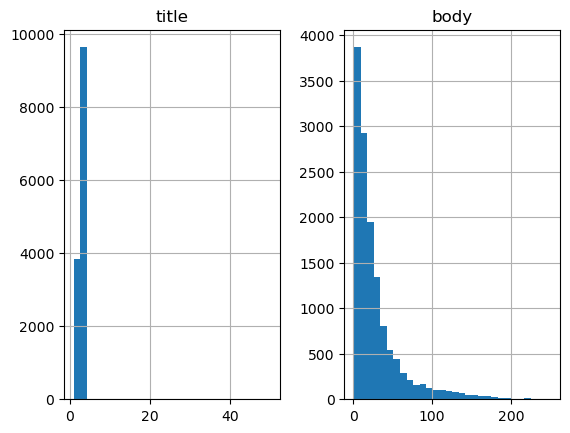

In [14]:
# Understanding the distribution of the sequences
body_word_count = []
title_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_body']:
      body_word_count.append(len(i.split()))

for i in data['cleaned_title']:
      title_word_count.append(len(i.split()))

length_df = pd.DataFrame({'title':title_word_count, 'body':body_word_count})

length_df.hist(bins = 30)
plt.show()

In [15]:
cnt=0
for i in data['cleaned_title']:
    if(len(i.split())<=8):
        cnt=cnt+1
print("Title % < than 8 words")
print(cnt/len(data['cleaned_title']))
print('-' * 80)
cnt=0
print("Body % < than 120 words")
for i in data['cleaned_body']:
    if(len(i.split())<= 120):
        cnt=cnt+1
print(cnt/len(data['cleaned_body']))

Title % < than 8 words
0.9971860189573459
--------------------------------------------------------------------------------
Body % < than 120 words
0.9672689573459715


In [16]:
max_title_len=8
max_body_len=120

In [17]:
#Let us select the title and body whose length falls below or equal to max_title_len and max_body_len

cleaned_title =np.array(data['cleaned_title'])
cleaned_body=np.array(data['cleaned_body'])

short_title=[]
short_body=[]

for i in range(len(cleaned_body)):
    if(len(cleaned_title[i].split())<=max_title_len and len(cleaned_body[i].split())<=max_body_len):
        short_title.append(cleaned_title[i])
        short_body.append(cleaned_body[i])
        
df=pd.DataFrame({'title':short_title,'body':short_body})
df.head(1800)

,title,body
0,invalid,https github com softuni programming basics book java bg blob master chapter simple calculations md judge https github com softuni programming basics book java bg blob master assets chapter images...
1,rk,heroku api
2,all,app name bundle id uk co channel ios od itunes id itunes url https itunes apple com gb app id mt uo app version seller channel developer channel supported devices ipad wifi ipad iphone ipadthirdge...
3,api,hi wonder contributing api something might interested starting anything wanted feedback
4,fix,return users created post
...,...,...
1795,is sweet,loaded cleared cache data pixel icons awesome
1796,vs,returns complexinfinity returns infinity probably complexinfinity
1797,next steps,follow user parse tag password reset macro accomadation
1798,add me,adding map hi everyone track addition map found longitude latitude


In [18]:
# Adding special tokens sostok and eostok as START and END tokens of title
df['title'] = df['title'].apply(lambda x : 'sostok '+ x + ' eostok')

In [19]:
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['body']),np.array(df['title']),test_size=0.1,random_state=0,shuffle=True) 

## Tokenizing 

### Body Tokenizer

In [20]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

In [21]:
thresh=3

cnt=0 ### Number of rare words -> words appearing less than the thresh
tot_cnt=0 ### Vocabulary size
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 69.34243444420422
Total Coverage of rare words: 9.503369190528158


In [22]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_body_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_body_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

In [23]:
x_voc

9927

### Title Tokenizer

In [24]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

In [25]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 86.0908775580992
Total Coverage of rare words: 14.012462747222976


In [26]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_title_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_title_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

In [27]:
y_tokenizer.word_counts['sostok'],len(y_tr)   

(11725, 11725)

In [28]:
### Delete row with only Start and End Tokens
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [29]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

## Model building

In [30]:
K.clear_session()

latent_dim = 300
embedding_dim=100

# Encoder
encoder_inputs = Input(shape=(max_body_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary() 

Metal device set to: Apple M1


2023-01-12 19:42:33.816328: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-12 19:42:33.816578: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 120)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 120, 100)     992700      ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 120, 300),   481200      ['embedding[0][0]']              
                                 (None, 300),                                                     
                                 (None, 300)]                                                     
                                                                                              

In [31]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')


In [32]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)


In [33]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=8,callbacks=[es],batch_size=128, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))


Epoch 1/8


2023-01-12 19:42:34.459559: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-12 19:42:36.777003: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


87/87 [==============================] - ETA: 0s - loss: 2.3261  

2023-01-12 21:55:16.346264: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


87/87 [==============================] - 7982s 92s/step - loss: 2.3261 - val_loss: 2.0039
Epoch 2/8
87/87 [==============================] - 7916s 91s/step - loss: 1.9497 - val_loss: 1.9345
Epoch 3/8
87/87 [==============================] - 7840s 90s/step - loss: 1.8714 - val_loss: 1.8975
Epoch 4/8
87/87 [==============================] - 7840s 90s/step - loss: 1.8162 - val_loss: 1.9302
Epoch 5/8
87/87 [==============================] - 7854s 90s/step - loss: 1.7769 - val_loss: 1.8365
Epoch 6/8
87/87 [==============================] - 7875s 91s/step - loss: 1.7367 - val_loss: 1.8292
Epoch 7/8
87/87 [==============================] - 8074s 93s/step - loss: 1.6969 - val_loss: 1.7967
Epoch 8/8
87/87 [==============================] - 8098s 93s/step - loss: 1.6662 - val_loss: 1.7855


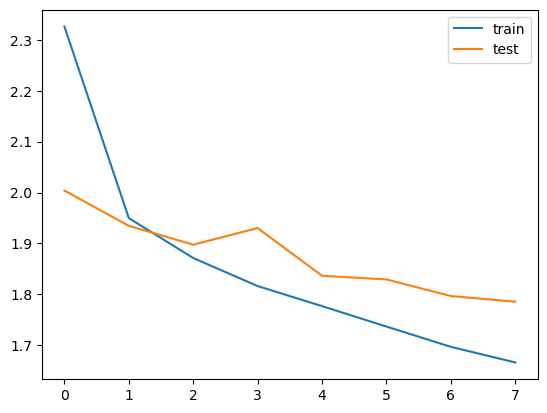

In [34]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [35]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [36]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_body_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [37]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_body_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [40]:
def seq2title(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2body(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [43]:
for i in range(0,1000):
    print("Body:",seq2body(x_tr[i]))
    print("Original title:",seq2title(y_tr[i]))
    print("Predicted title:",decode_sequence(x_tr[i].reshape(1,max_body_len)))
    print("\n")

Body: https github com tgstation tgstation pull https github com tgstation tgstation pull https github com tgstation tgstation pull https github com tgstation tgstation pull https github com tgstation tgstation pull https github com tgstation tgstation pull https github com tgstation tgstation pull https github com tgstation tgstation pull https github com tgstation tgstation pull https github com tgstation tgstation pull https github com tgstation tgstation pull https github com tgstation tgstation pull https github com tgstation tgstation pull https github com tgstation tgstation pull https github com tgstation tgstation pull https github com tgstation tgstation pull need input https github com tgstation tgstation pull https github com tgstation tgstation pull 
Original title: pr 
1/1 [==============================] - 0s 17ms/step
Predicted title:  add


Body: variable greater variable https github com blob fd ff src lift java 
Original title: code review 
1/1 [=====================

1/1 [==============================] - 0s 17ms/step
Predicted title:  fix page


Body: project helpfull project cant use android stb someone provide android version tell android version thanks 
Original title: in android 
1/1 [==============================] - 0s 16ms/step
Predicted title:  fix


Body: description clicked preview camera button clicked auto detect rois spit error error msg invalid deleted object error line error autotracker auto detect rois callback line handles error gui line varargin error autotracker line gui gui state varargin error matlab graphics internal read hobject autotracker auto detect rois callback hobject hobject error evaluating callback 
Original title: test bug report 
1/1 [==============================] - 0s 16ms/step
Predicted title:  error


Body: another thursday time accomplish recurring today 
Original title: log hour ilegra 
1/1 [==============================] - 0s 16ms/step
Predicted title:  log hour ilegra


Body: view full bugsee session ios

1/1 [==============================] - 0s 19ms/step
Predicted title:  fix


Body: create folder structure like database folder build database connection public folder client side src folder server side tests folder test 
Original title: task 
1/1 [==============================] - 0s 16ms/step
Predicted title:  add


Body: split multiple sub line possible considerations include multiple tabs logo color schemes text presentation 
Original title: the gui 
1/1 [==============================] - 0s 16ms/step
Predicted title:  fix


Body: use calc https github com calc cli https org efficient api 
Original title: add api 
1/1 [==============================] - 0s 15ms/step
Predicted title:  add


Body: currently binary ninja supports pdb format older pdb format 
Original title: support 
1/1 [==============================] - 0s 16ms/step
Predicted title:  add


Body: remove hyperlink tv shuosc org add hyperlink shuosc org add hyperlink blog shuosc org 
Original title: update site info 
1/1 

1/1 [==============================] - 0s 16ms/step
Predicted title:  found bug


Body: im getdata data error problem sorry im dont speak english hope understand image https user images githubusercontent com png 
Original title: have bug 
1/1 [==============================] - 0s 16ms/step
Predicted title:  de


Body: create organization test https try gitea io supertest new migration organization test https try gitea io supertest installer framework see watchers test https try gitea io supertest installer framework watchers look picture please https user images githubusercontent com aaf dbd png 
Original title: repo bug 
1/1 [==============================] - 0s 16ms/step
Predicted title:  found bug


Body: return key stopped working emmet enabled 
Original title: on atom 
1/1 [==============================] - 0s 16ms/step
Predicted title:  no


Body: added lot useless commits repo base functionality done together 
Original title: clean up 
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 15ms/step
Predicted title:  add page


Body: existing database time consuming write models would great able generate definition batches 
Original title: db tools 
1/1 [==============================] - 0s 20ms/step
Predicted title:  add


Body: changes add test cases see todos add constant function takes argument returns function given argument always returns add swap function takes pair returns add flip function takes function type returns function type add curry function takes function returns function type add function takes function returns function type 
Original title: library 
1/1 [==============================] - 0s 15ms/step
Predicted title:  add unit tests


Body: know everyone likes code coverage etc consider following time go test go list grep vendor real user sys time make test real user sys know make target trying smart things developing time want know code builds tests pass turn vim plugin setup run make every save go file compu

1/1 [==============================] - 0s 16ms/step
Predicted title:  add


Body: file called choosing optimization algorithm find optimal embedding parameter program possible hope file thank much 
Original title: is missing 
1/1 [==============================] - 0s 16ms/step
Predicted title:  fix


Body: getting following warn slackistrano error slack warn slackistrano error rails ruby config deploy rb set slackistrano channel webhook url curl message server deploying without 
Original title: open ssl error 
1/1 [==============================] - 0s 15ms/step
Predicted title:  error on


Body: add jarvis aur 
Original title: add to 
1/1 [==============================] - 0s 15ms/step
Predicted title:  add me


Body: hi example write insert bank account account amount values returns id pg syntax https www postgresql org docs static sql insert html use returning 
Original title: syntax in doc 
1/1 [==============================] - 0s 15ms/step
Predicted title:  fix


Body: une version

1/1 [==============================] - 0s 17ms/step
Predicted title:  fix


Body: test css line https github com blob bd df test css 
Original title: rule is empty 
1/1 [==============================] - 0s 16ms/step
Predicted title:  fix


Body: update problem activate ads title load ad units ads working well could problem update worked fine reported https com page builder released amp comment 
Original title: test the ads 
1/1 [==============================] - 0s 18ms/step
Predicted title:  de


Body: rb dumped add support files 
Original title: support 
1/1 [==============================] - 0s 17ms/step
Predicted title:  add


Body: merging branch test dev previous pr https github com kyle webhook test pull resolves test https atlassian net browse test 
Original title: test dev 
1/1 [==============================] - 0s 15ms/step
Predicted title:  test


Body: avoided figuring use binding make local dev faster currently implemented static binding see https www com documentation 
O

1/1 [==============================] - 0s 15ms/step
Predicted title:  is


Body: problem 
Original title: found bug 
1/1 [==============================] - 0s 15ms/step
Predicted title:  found bug


Body: generating map clients enough food 
Original title: not enough 
1/1 [==============================] - 0s 15ms/step
Predicted title:  add


Body: overall element count one says analyzing input dat result linear regression values intercept slightly enough give wrong answer two decimal places need find bug maybe exhausted like hours 
Original title: off by 
1/1 [==============================] - 0s 15ms/step
Predicted title:  fix


Body: user clicks layer name application must select layer show name today description 
Original title: layer 
1/1 [==============================] - 0s 16ms/step
Predicted title:  add page


Body: successfully installed windows need use camera want try os version hints use code without recompile everything guess linux version compatibility thanks lot 
Origin

1/1 [==============================] - 0s 15ms/step
Predicted title:  add


Body: hi thanks amazing tool sure think started seeing new apple filesystem fileicon set toto icons png var folders lq ds hr gn fileicon aup icon png file directory failed create resource fork icons typically means input file valid image file var folders lq ds hr gn fileicon aup icon png fileicon error aborting due unexpected error system specs osx uname darwin darwin kernel version thu aug root release thoughts 
Original title: support 
1/1 [==============================] - 0s 15ms/step
Predicted title:  support


Body: hey john ideas port use nix platform see pulling api dictionary hashes creation based local binaries could get another way pre make dictionary would like run tool nix platform thanks 
Original title: for box 
1/1 [==============================] - 0s 15ms/step
Predicted title:  add


Body: took example updated key lat long get error fatal error call member function non object forecast example 

1/1 [==============================] - 0s 15ms/step
Predicted title:  add


Body: hi keep getting error running canu running jobs first attempt starting bat concurrent execution fri jul gb free disk space processes concurrently cd unitigger unitigger sh unitigger finished fri jul second gb free disk space failed retry running jobs second attempt starting bat concurrent execution fri jul gb free disk space processes concurrently cd unitigger unitigger sh unitigger finished fri jul split gb free disk space failed tried times giving abort abort canu snapshot changes fc ff af ab abort panic mostly error occurred canu stopped abort try restarting work ask help abort ideas 
Original title: failed 
1/1 [==============================] - 0s 16ms/step
Predicted title:  build


Body: able watch directory changes fs dir watch changes 
Original title: add method 
1/1 [==============================] - 0s 15ms/step
Predicted title:  add


Body: open new window tab view repo use back button paging l

1/1 [==============================] - 0s 15ms/step
Predicted title:  add


Body: user story developer want update node use npm see using lts supported till december acceptance criteria project uses node travis uses node vagrant uses node docker uses node dev docker hub additional info https github com nodejs lts lts schedule 
Original title: update to node 
1/1 [==============================] - 0s 23ms/step
Predicted title:  add


Body: using react native tab view working perfectly fine want tab bar bottom screen trying modify stylesheet happening please help want like img https user images githubusercontent com da png 
Original title: tab bar 
1/1 [==============================] - 0s 16ms/step
Predicted title:  fix


Body: recently changed bucket prod outputs new one different name something need aware 
Original title: change 
1/1 [==============================] - 0s 15ms/step
Predicted title:  add


Body: wanted yeti got crash https pastebin com tf version forge version tried tim

1/1 [==============================] - 0s 15ms/step
Predicted title:  add page


Body: add debug puts access source missing comments 
Original title: docs and debug 
1/1 [==============================] - 0s 16ms/step
Predicted title:  add


Body: creating complex else structures quite hard method chain growing rxjs nice solution https github com reactive extensions rxjs blob master doc api core operators md takes condition method parameters 
Original title: add if 
1/1 [==============================] - 0s 15ms/step
Predicted title:  add


Body: sentence report reason mobs dont hp bar hitting sound also attack thats case 
Original title: report by 
1/1 [==============================] - 0s 15ms/step
Predicted title:  fix


Body: navigation bar contains link new post page page works way post update page form appear lack information 
Original title: create post 
1/1 [==============================] - 0s 16ms/step
Predicted title:  keep css


Body: official pod docs broken https mesosphe

1/1 [==============================] - 0s 16ms/step
Predicted title:  add


Body: server start version dev php binary version server os windows bit game client win server thread info loading properties configuration server thread warning online mode turned server properties server thread warning xbox live authentication disabled server thread info selected english eng base language server thread info opening server server thread info distributed gpl license version later server thread info loading recipes server thread info loading resource packs server thread info preparing level lobby server thread info preparing level server thread info preparing level bin php php exe exit 
Original title: server not start 
1/1 [==============================] - 0s 15ms/step
Predicted title:  error


Body: tried move dir rsync host another start ldap server work serveur get started admin credentials valid anything setup 
Original title: how to migrate 
1/1 [==============================] - 0s 18ms/

1/1 [==============================] - 0s 16ms/step
Predicted title:  add


Body: junit https github com junit team junit introduces new extension mechanism http junit org junit docs current user guide extensions would nice junit interest officially supporting junit 
Original title: support 
1/1 [==============================] - 0s 15ms/step
Predicted title:  add


Body: tab bar shown top pages bottom users access pages easily example application tab bar seen following link https org 
Original title: tab bar 
1/1 [==============================] - 0s 15ms/step
Predicted title:  fix css


Body: move toolkit personal dropbox google drive invite author continue 
Original title: post 
1/1 [==============================] - 0s 17ms/step
Predicted title:  add


Body: project needs less version content like http www com img free logo png logo simple mapping https html net story html template get started questions answer page making get involved 
Original title: and logo 
1/1 [===============

1/1 [==============================] - 0s 15ms/step
Predicted title:  add


Body: work dap team use component start end test cases 
Original title: with 
1/1 [==============================] - 0s 16ms/step
Predicted title:  support


Body: page links blogs left side nav bar cms page 
Original title: blog link page 
1/1 [==============================] - 0s 16ms/step
Predicted title:  add page


Body: map rather nl regions meter clearly better data available vary meters nl data obtained open earth site like https nl display dataset documentation 
Original title: maps 
1/1 [==============================] - 0s 15ms/step
Predicted title:  add


Body: let us say use example let async int let try await username pass let try await let try await return value print value users would make 
Original title: and 
1/1 [==============================] - 0s 17ms/step
Predicted title:  add


Body: pick something sprint planning asap least make tickets waffle make visible 
Original title: just do it 
1

1/1 [==============================] - 0s 15ms/step
Predicted title:  fix page


Body: types like might better implemented trait would get rid nesting 
Original title: vs 
1/1 [==============================] - 0s 15ms/step
Predicted title:  add


Body: icon original https cloud githubusercontent com assets acf fa fd png simulator screen shot https cloud githubusercontent com assets ae bd png simulator screen shot https cloud githubusercontent com assets af dbc png simulator screen shot https cloud githubusercontent com assets cf png simulator screen shot https cloud githubusercontent com assets fc ac dd png simulator screen shot https cloud githubusercontent com assets png 
Original title: us dev images 
1/1 [==============================] - 0s 15ms/step
Predicted title:  add


Body: ra currently logs cash shop think able view flux suggestion 
Original title: log 
1/1 [==============================] - 0s 15ms/step
Predicted title:  add unit tests


Body: problem health bar character

1/1 [==============================] - 0s 15ms/step
Predicted title:  add


Body: file swarm reference list md https docs docker com swarm reference list cc cannot find related documents without add command use docker node list list nodes commands docker swarm init docker run swarm manage 
Original title: docker node list 
1/1 [==============================] - 0s 29ms/step
Predicted title:  add


Body: admin rights https user images githubusercontent com dfb png 
Original title: admin 
1/1 [==============================] - 0s 16ms/step
Predicted title:  add page


Body: uses instead deprecated rails 
Original title: allow 
1/1 [==============================] - 0s 16ms/step
Predicted title:  add


Body: cannot find files 
Original title: not found files 
1/1 [==============================] - 0s 17ms/step
Predicted title:  add


Body: noticed couple improvements made docs https capstone coal github io docs page specify debian used build qgis debian recently released https www debian 

1/1 [==============================] - 0s 17ms/step
Predicted title:  add


Body: set path crawler function working like var path http www google com var crawler require js crawler new crawler configure depth crawl path function page console log page url 
Original title: path in 
1/1 [==============================] - 0s 17ms/step
Predicted title:  add


Body: context paging mechanism must tested problem tests use database main application guarantee tests run environment collection solution separate main database test database drop collection every time test run 
Original title: tests for 
1/1 [==============================] - 0s 17ms/step
Predicted title:  found bug


Body: hi shall combine py documents call different names looking forward chatting tomorrow 
Original title: docs 
1/1 [==============================] - 0s 17ms/step
Predicted title:  add


Body: really nice complete lack tests even unclear tested least like could automatically checked possible regression say would happ

KeyboardInterrupt: 